## Bonn Database Analysis

#### Importing Libraries

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.signal import welch, butter, filtfilt, decimate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#### Importing data from the Bonn Database

In [ ]:
# Defining classes/directories
directories = ['Z', 'O', 'N', 'F', 'S']
base_path = './bonn_database/'

# Initializing an auxiliar dictionary to store data
data_dict = {
# healthy volunteer data
    "Z": [],  # eyes open
    "O": [],  # eyes closed
# presurgical diagnosis data
    "N": [],  # not seizure - within the lesion area (hipocampus)
    "F": [],  # not seizure - within the other hemisphere's hipocampus
    "S": []   # seizure data
}

original_fs = 173.61 # sampling frequency

# Reading data from each directory
for dir_name in directories:
    dir_path = os.path.join(base_path, dir_name)
    for file_name in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_name)
        data = np.loadtxt(file_path)
        data_dict[dir_name].append(data)

# Convert lists to numpy ndarrays
for key in data_dict.keys():
    data_dict[key] = np.array(data_dict[key])

# Print shapes of data for verification
for key, value in data_dict.items():
    print(f" Data {key} shape: {value.shape}")

 Data Z shape: (100, 4097)
 Data O shape: (100, 4097)
 Data N shape: (100, 4097)
 Data F shape: (100, 4097)
 Data S shape: (100, 4097)


#### Filtering and downsampling the data

In [4]:
# defines the filter to be used
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [5]:
# filtering step
lowcut = 0.5
highcut = 40
down_factor = 2 # downsampling factor

filt_dict = {key: decimate(bandpass_filter(data, lowcut, highcut, original_fs), down_factor)
             for key, data in data_dict.items()}

fs = original_fs / down_factor

### Visualizing the EEG's and their spectrum

This is important so we can see the 2 features we are working with:
- The EEG's (raw, time-based data)
- The spectrum of the EEG's (frequency domain data)

In [6]:
# calculates the power spectral density for each data
psd_dict = {}

frequencies = []

for key, item in filt_dict.items():
    frequencies, psd_dict[key] = welch(item, fs=fs, nperseg=256)

print(f"PSD Z shape: {psd_dict["Z"].shape}")
# print(frequencies) # 0-43 Hz, near Nyquist frequency


PSD Z shape: (100, 129)


#### Plotting Samples

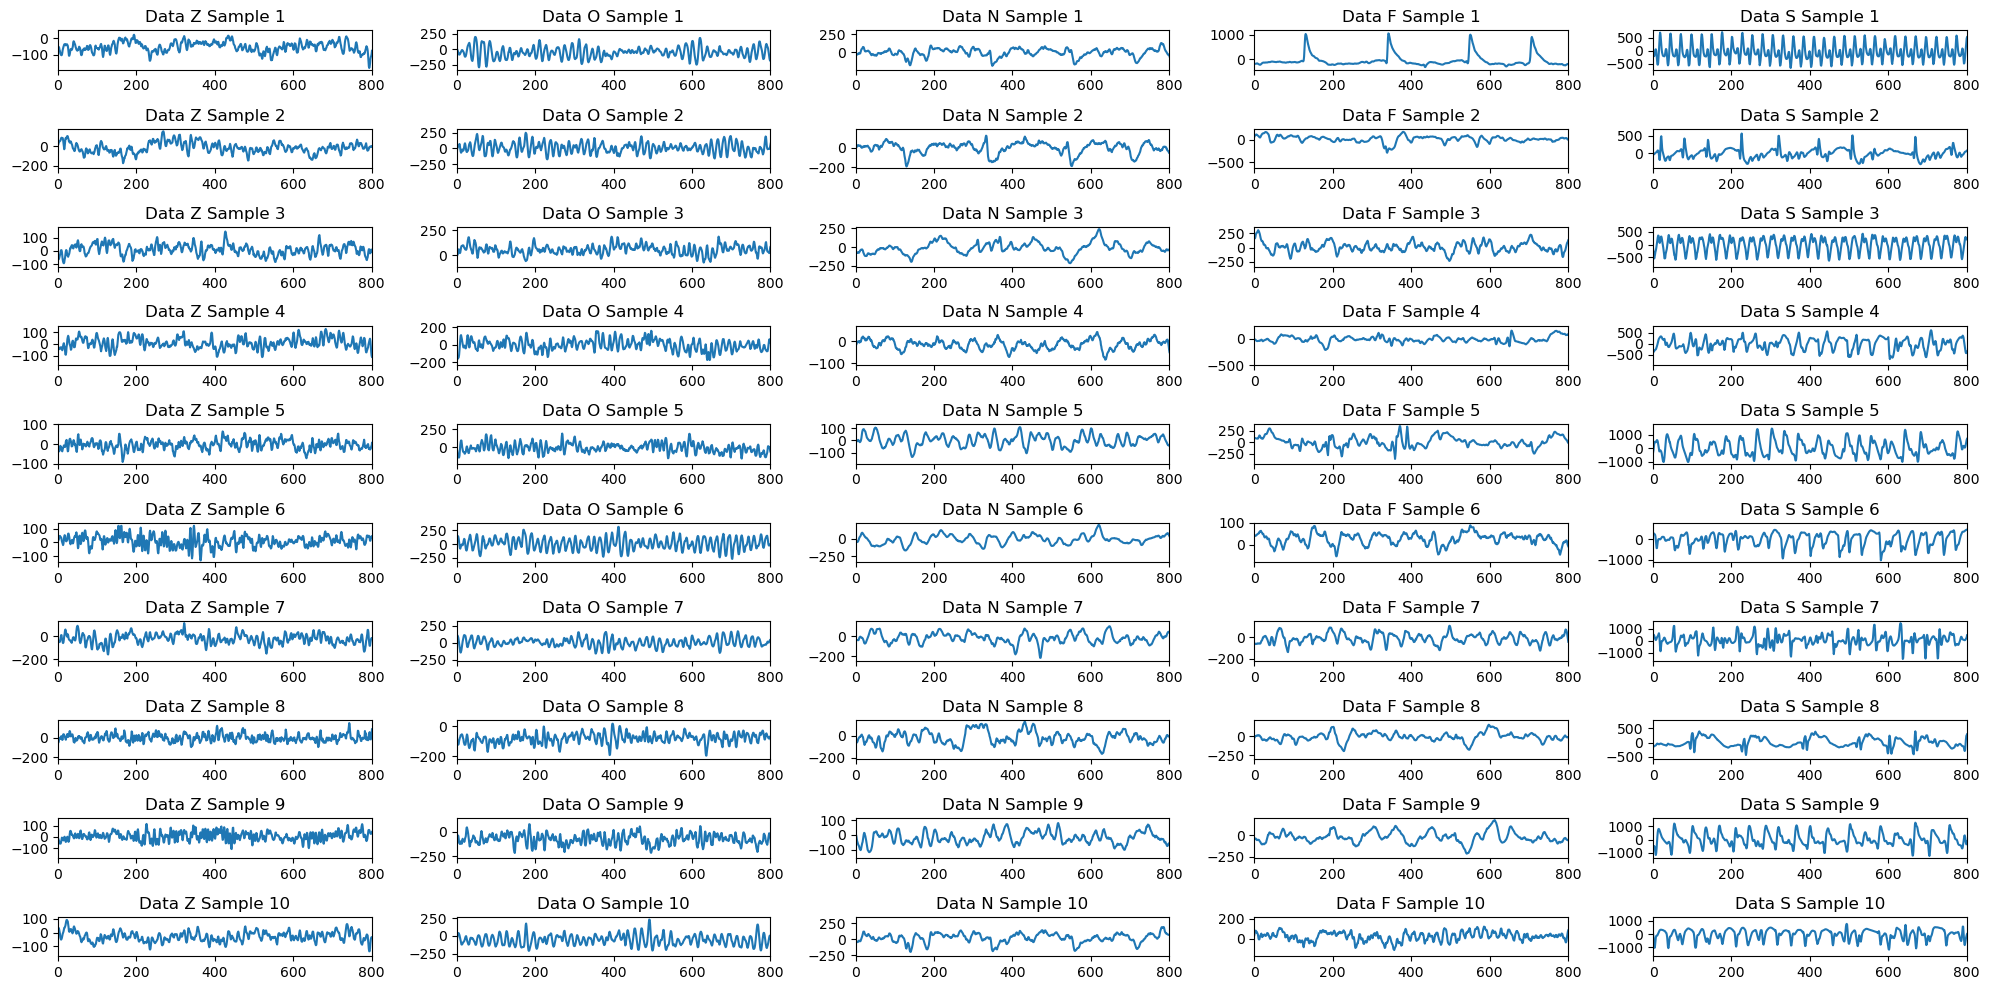

In [7]:
samples_to_plot = 10

# also plot the data in the time domain
fig, axs = plt.subplots(samples_to_plot, 5, figsize=(20, 10))

# Plot time domain data for each dataset
for i in range(samples_to_plot):
    for col, class_name in enumerate(data_dict.keys()):
        axs[i, col].plot(data_dict[class_name][i])
        axs[i, col].set_xlim(0, 800)
        axs[i, col].set_title(f'Data {class_name} Sample {i+1}')

plt.tight_layout()
plt.show()

#### Plotting FFT's

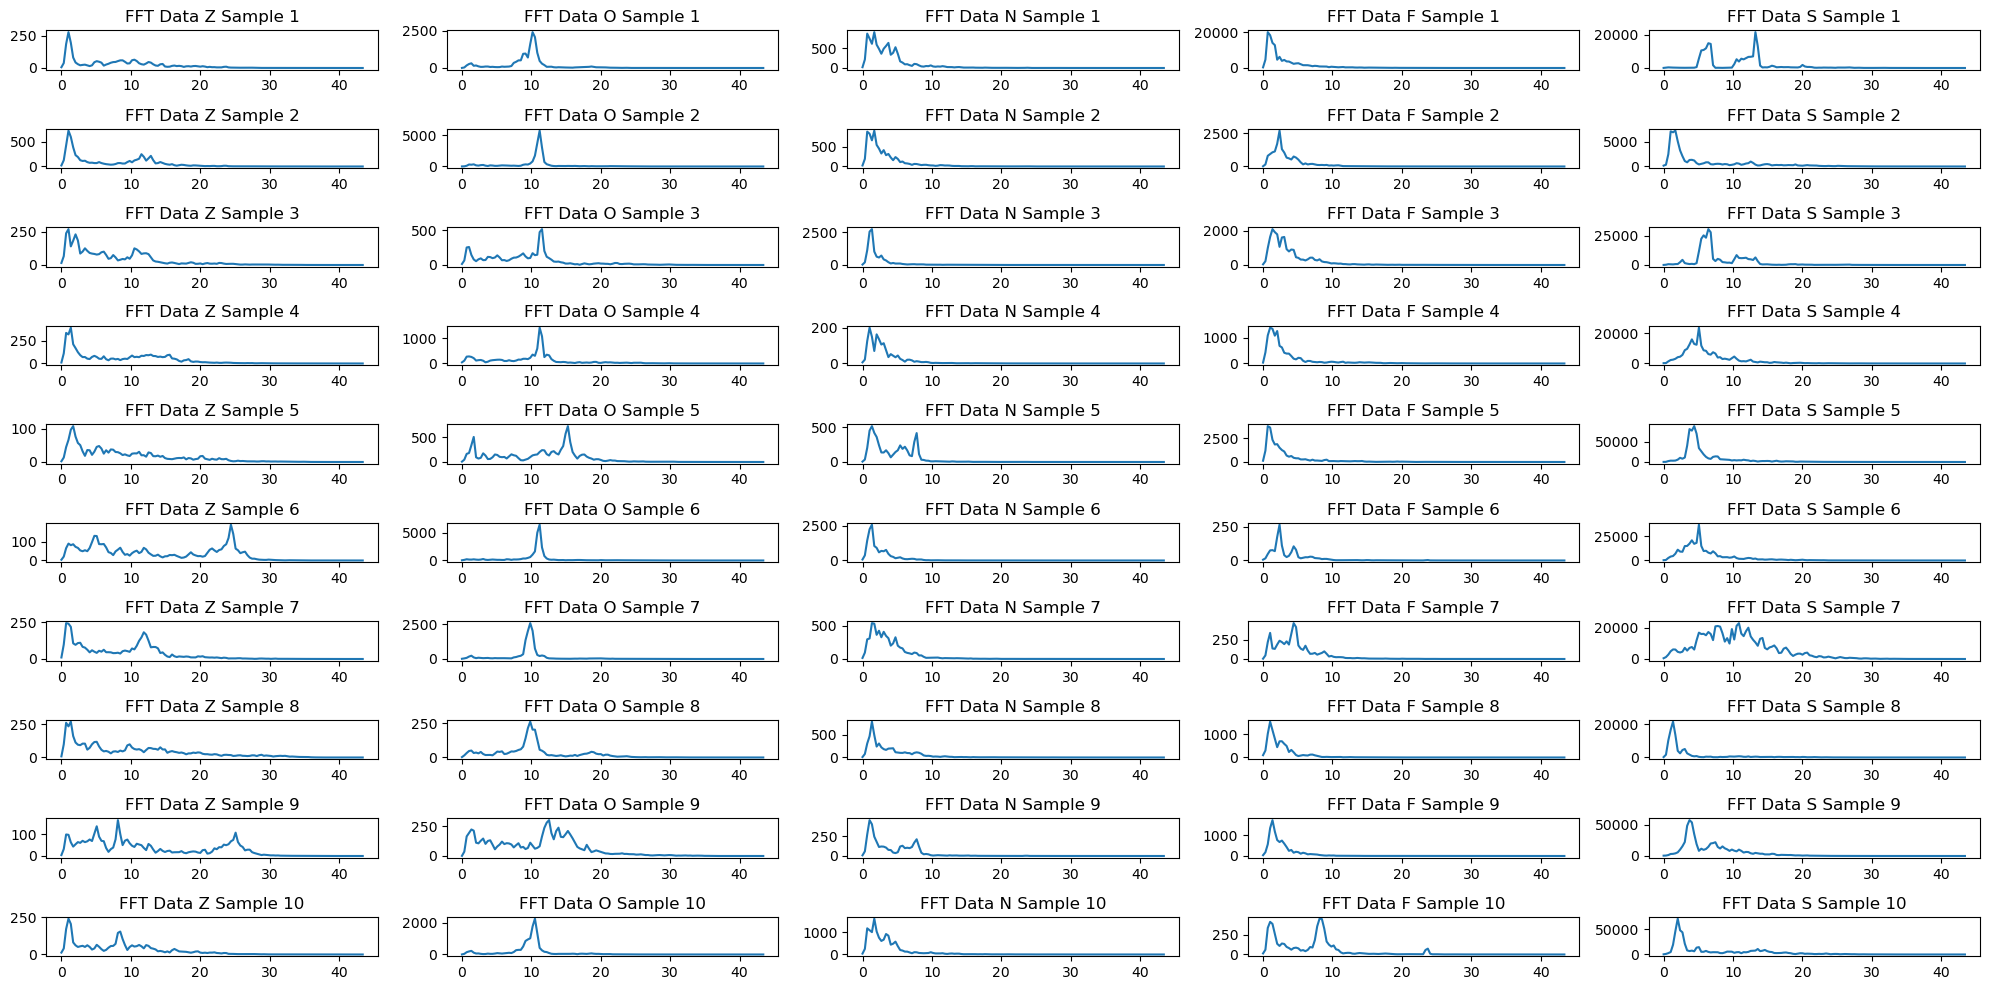

In [8]:
fig, axs = plt.subplots(samples_to_plot, 5, figsize=(20, 10))

# Plot FFTs for each dataset
for i in range(samples_to_plot):
    for col, class_name in enumerate(data_dict.keys()):
        axs[i, col].plot(frequencies, psd_dict[class_name][i])
        axs[i, col].set_title(f'FFT Data {class_name} Sample {i+1}')

# Adjust layout
plt.tight_layout()
plt.show()

### Doing some feature engineering
The main features i aim to extract are:

- the power of the EEG on each of the main literature frequency bands (delta, theta, alpha, beta, gamma);
- and the relative power of each of these bands;

Maybe i will also try to extract some other features like the Hjorth parameters, the fractal dimension and the entropy...

In [9]:
def band_power(frequencies, psd, band):
    """ Calcula a potência dentro de uma banda de frequência específica """
    band_idx = np.logical_and(frequencies >= band[0], frequencies <= band[1])  
    return np.trapz(psd[band_idx], frequencies[band_idx])

bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 40)
}

band_powers_df_dict = {}

for key, psd_list in psd_dict.items():
    band_powers_df_dict[key] = pd.DataFrame(
        {band: [band_power(frequencies, psd, bands[band]) for psd in psd_list] for band in bands}
        )

# print(band_powers_df_dict["Z"].shape) # (100, 5), 5 band powers per sample (100 samples)

In [10]:
norm_band_powers_df_dict = {}

for key, band_powers_df in band_powers_df_dict.items():
    norm_band_powers_df_dict[key] = band_powers_df.div(band_powers_df.sum(axis=1), axis=0)

# print(norm_band_powers_df_dict["Z"].shape) # (100, 5), 5 band powers per sample (100 samples)

#### Visualizing the features on a 3d point cloud

In [11]:
import plotly.express as px
import pandas as pd

# combining data onto single df (plotly express requirement)
all_classes_df = pd.concat([
    band_powers_df.assign(Class=key) for key, band_powers_df in band_powers_df_dict.items()
])

classes_to_be_plotted = ["Delta", "Alpha", "Beta"]

# scatter matrix instead of 3d scatter plot
fig = px.scatter_matrix(
    all_classes_df,
    dimensions = bands.keys(),
    color='Class',  # Color by class
    title='3D Scatter Plot of Band Powers',
    # labels={'Delta': 'Delta Power', 'Theta': 'Theta Power', 'Alpha': 'Alpha Power'}
)

fig.show()

### Constructing classifiers based on the 4 different feature sets

#### Separating data between train and test

In [12]:
time_data = {
    key: data for key, data in data_dict.items()
}

frequency_data = {
    key: psd for key, psd in psd_dict.items()
}

band_power_data = {
    key: band_powers_df for key, band_powers_df in band_powers_df_dict.items()
}

normalized_band_power_data = {
    key: norm_band_powers_df for key, norm_band_powers_df in norm_band_powers_df_dict.items()
}

# split data in dict's into train and test sets
def split_data(data_dict, test_size=0.2, random_state=42):
    X = []
    y = []
    for label, data in data_dict.items():
        X.append(data)
        y.extend([label] * len(data))
    X = np.vstack(X)
    y = np.array(y)
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# splitting data into train and test sets
X_train_time, X_test_time, y_train_time, y_test_time = split_data(time_data)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = split_data(frequency_data)
X_train_band, X_test_band, y_train_band, y_test_band = split_data(band_power_data)
X_train_norm_band, X_test_norm_band, y_train_norm_band, y_test_norm_band = split_data(normalized_band_power_data)

# printing shapes for berification
print("Time-domain data:", X_train_time.shape, X_test_time.shape)
print("Frequency-domain data:", X_train_freq.shape, X_test_freq.shape)
print("Band power data:", X_train_band.shape, X_test_band.shape)
print("Normalized band power data:", X_train_norm_band.shape, X_test_norm_band.shape)

Time-domain data: (400, 4097) (100, 4097)
Frequency-domain data: (400, 129) (100, 129)
Band power data: (400, 5) (100, 5)
Normalized band power data: (400, 5) (100, 5)


#### Setting and training basic MLP classifiers

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Input, Normalization
from keras.layers import Dropout
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Function to create a basic MLP model
def create_mlp(input_dim, num_classes):
    model = Sequential([
        Input(shape=(input_dim,)),
        Normalization(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='Nadam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

# Function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test, feature_name):
    # Encode labels
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    
    # One-hot encode labels
    y_train_categorical = to_categorical(y_train_encoded)
    y_test_categorical = to_categorical(y_test_encoded)
    
    # Creating the model and adapting it to the training data
    model = create_mlp(X_train.shape[1], num_classes=y_train_categorical.shape[1])
    model.layers[0].adapt(X_train)

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        min_delta=0.001,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train_categorical,
        epochs=200,
        batch_size=8,
        verbose=1,
        validation_split=0.2,
        callbacks=[early_stopping]
    )
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)
    print(f"{feature_name} - Test Accuracy: {accuracy:.4f}")
    
    # Generate classification report
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    print(classification_report(y_test_encoded, y_pred_classes, target_names=encoder.classes_))

    # figure for accuracy and loss plots
    plt.figure(figsize=(20, 6))

    # plotting accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{feature_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # plotting loss too
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{feature_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # plotting the confusion matrix
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_test_encoded, y_pred_classes)
    
    # Normalize confusion matrix (optional)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot with seaborn for better visualization
    ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
                    xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f'{feature_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.tight_layout()
    plt.show()

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2221 - loss: 2.4175 - val_accuracy: 0.3375 - val_loss: 1.6686
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5143 - loss: 1.2928 - val_accuracy: 0.4250 - val_loss: 1.4416
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6598 - loss: 0.9826 - val_accuracy: 0.4750 - val_loss: 1.3868
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6970 - loss: 0.8606 - val_accuracy: 0.5000 - val_loss: 1.2842
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7217 - loss: 0.7826 - val_accuracy: 0.4875 - val_loss: 1.2738
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7700 - loss: 0.6825 - val_accuracy: 0.5375 - val_loss: 1.3073
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8363 - loss: 0.6826 - val_accuracy: 0.6125 - val_loss: 1.3161
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8715 - loss: 0.4230 - val_accuracy: 0.5375 - v

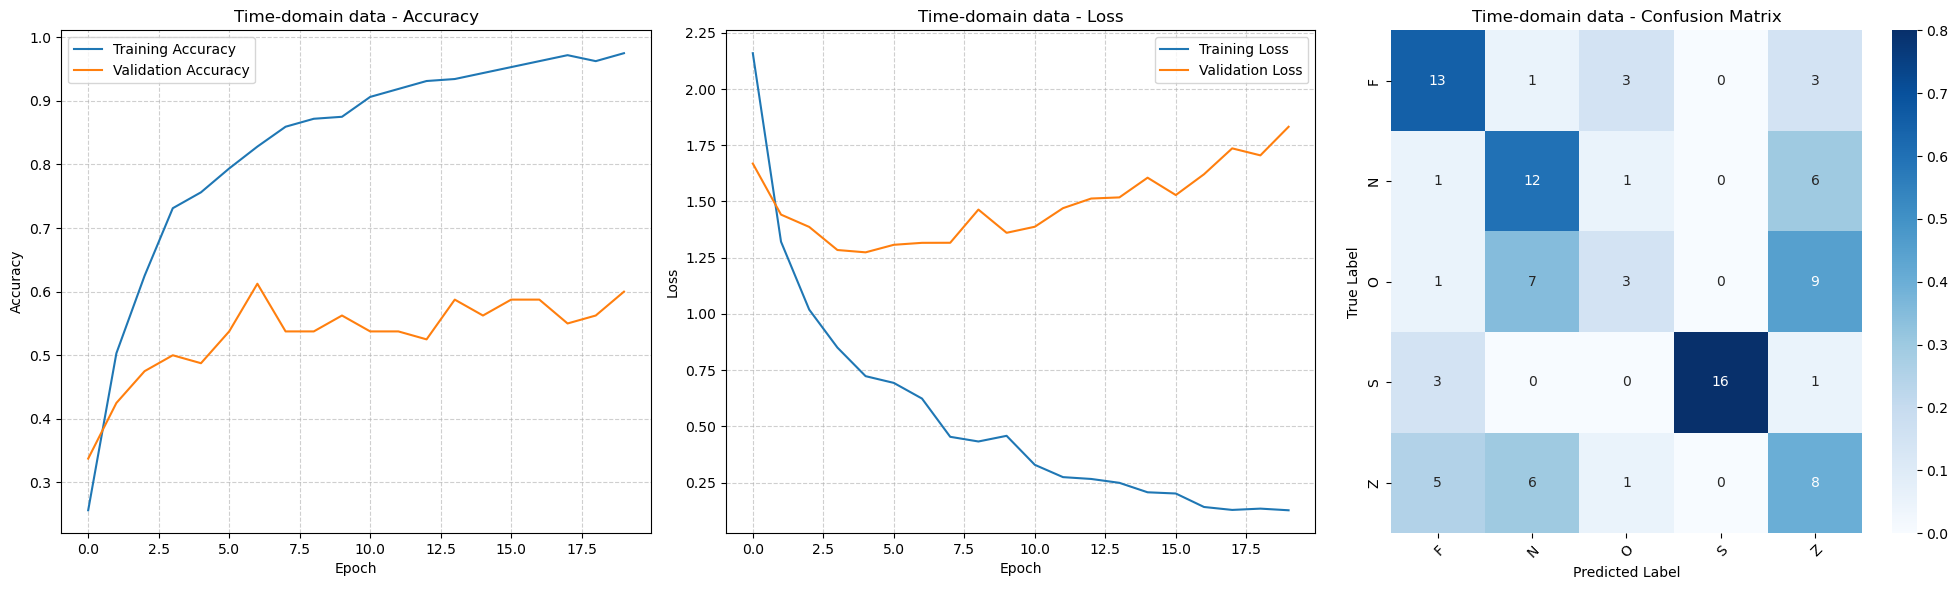

In [30]:
# Train and evaluate classifiers for each feature set
train_and_evaluate(X_train_time, X_test_time, y_train_time, y_test_time, "Time-domain data")

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2037 - loss: 1.6923 - val_accuracy: 0.3875 - val_loss: 1.4103
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4057 - loss: 1.3370 - val_accuracy: 0.4375 - val_loss: 1.3492
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3923 - loss: 1.2744 - val_accuracy: 0.5250 - val_loss: 1.2991
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4322 - loss: 1.2825 - val_accuracy: 0.3875 - val_loss: 1.2866
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4605 - loss: 1.2394 - val_accuracy: 0.4625 - val_loss: 1.2513
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4288 - loss: 1.1985 - val_accuracy: 0.5250 - val_loss: 1.2148
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4495 - loss: 1.2380 - val_accuracy: 0.5125 - val_loss: 1.1908
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4346 - loss: 1.1935 - val_accuracy: 0.5500 - v

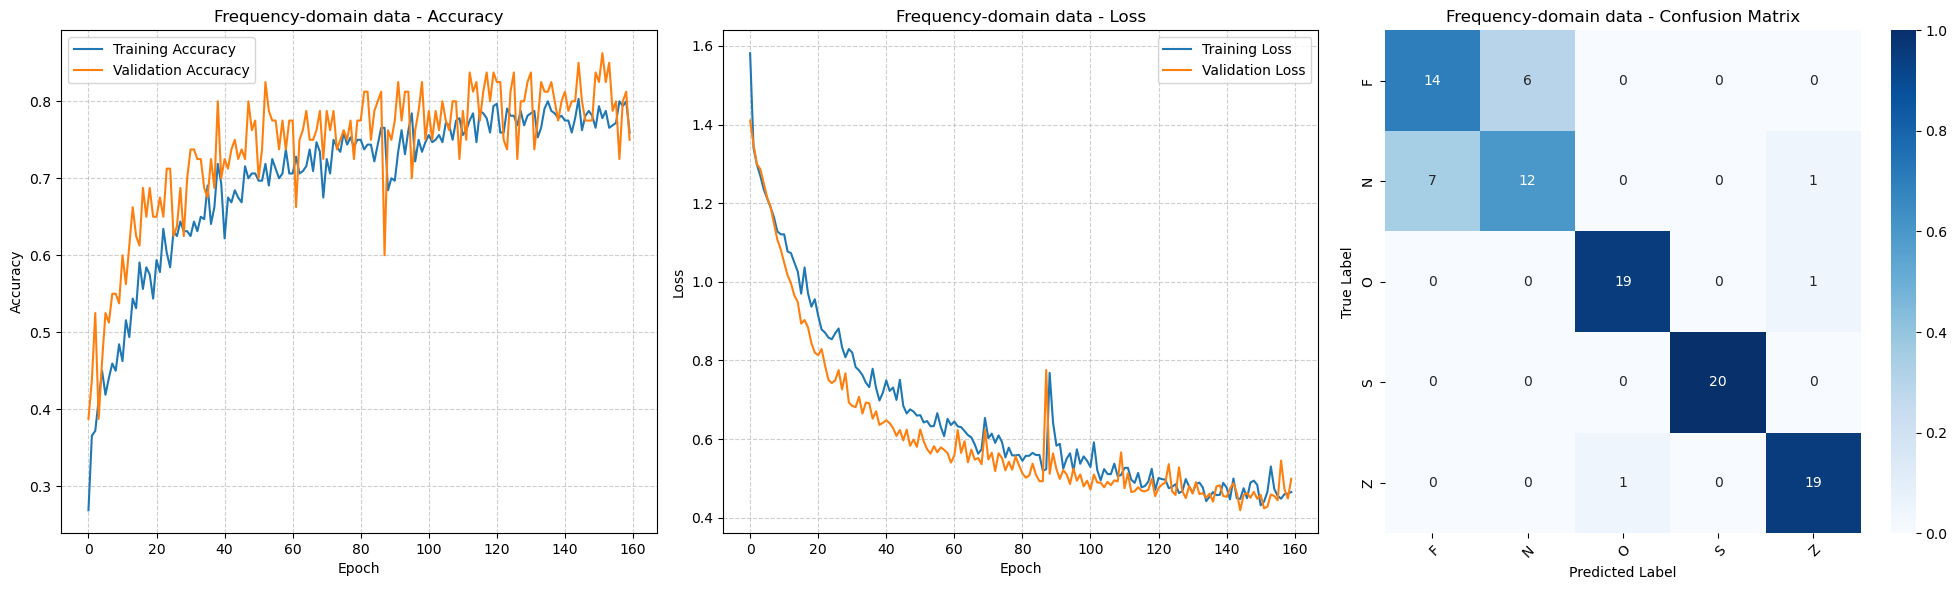

In [31]:
train_and_evaluate(X_train_freq, X_test_freq, y_train_freq, y_test_freq, "Frequency-domain data")

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2229 - loss: 1.5811 - val_accuracy: 0.3875 - val_loss: 1.5061
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3679 - loss: 1.4655 - val_accuracy: 0.3500 - val_loss: 1.4456
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3787 - loss: 1.3889 - val_accuracy: 0.3750 - val_loss: 1.3918
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4183 - loss: 1.3297 - val_accuracy: 0.3875 - val_loss: 1.3461
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4165 - loss: 1.2856 - val_accuracy: 0.4375 - val_loss: 1.3054
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4656 - loss: 1.2257 - val_accuracy: 0.4375 - val_loss: 1.2648
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4644 - loss: 1.2050 - val_accuracy: 0.4750 - val_loss: 1.2336
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4887 - loss: 1.1709 - val_accuracy: 0.5125 - v

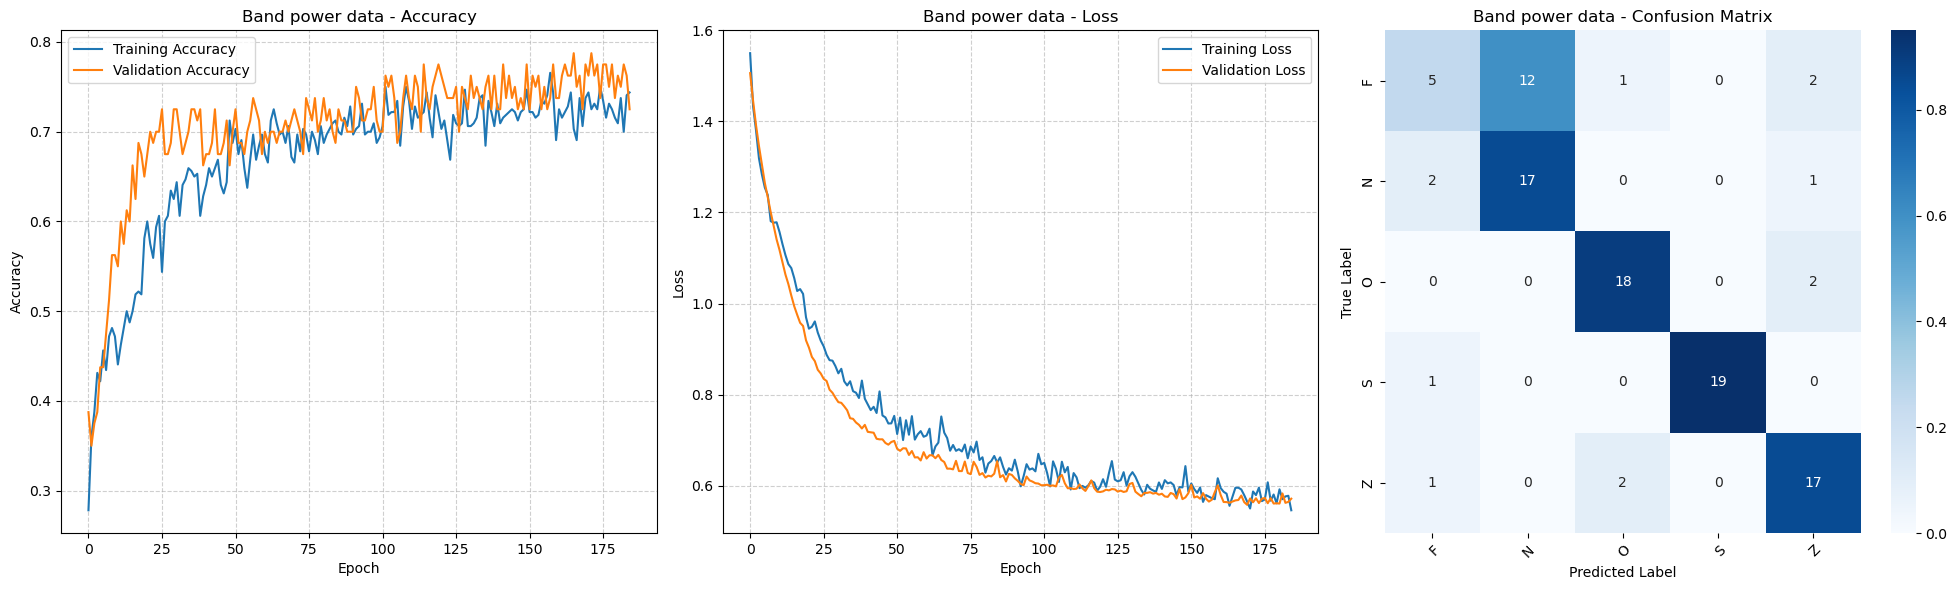

In [32]:
train_and_evaluate(X_train_band, X_test_band, y_train_band, y_test_band, "Band power data")

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3218 - loss: 1.6244 - val_accuracy: 0.4750 - val_loss: 1.4363
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4153 - loss: 1.4361 - val_accuracy: 0.6000 - val_loss: 1.2104
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5607 - loss: 1.2312 - val_accuracy: 0.6250 - val_loss: 1.0060
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6586 - loss: 1.0203 - val_accuracy: 0.6125 - val_loss: 0.8878
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5383 - loss: 1.0319 - val_accuracy: 0.6375 - val_loss: 0.8214
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5653 - loss: 0.9431 - val_accuracy: 0.6500 - val_loss: 0.7732
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5952 - loss: 0.8693 - val_accuracy: 0.6875 - val_loss: 0.7353
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6318 - loss: 0.8307 - val_accuracy: 0.6875 - v

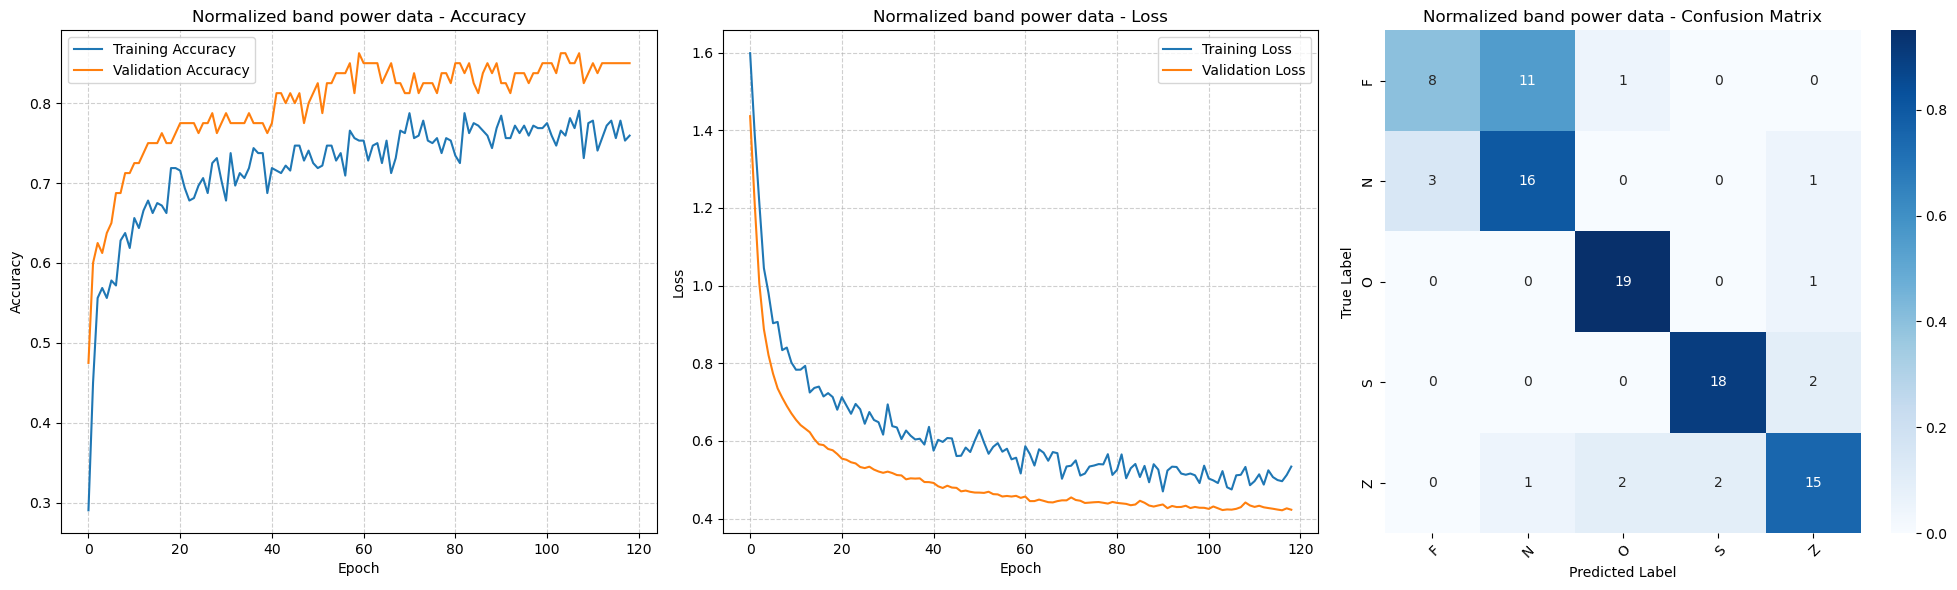

In [33]:
train_and_evaluate(X_train_norm_band, X_test_norm_band, y_train_norm_band, y_test_norm_band, "Normalized band power data")

#### Setting CNN's to classify time or frequency data

In [41]:
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
import seaborn as sns
os.environ["KERAS_BACKEND"] = "torch"

# Function to create a CNN model for 1D time series data
def create_cnn_time(input_shape, num_classes):
    model = Sequential([
        # Input shape: (sequence_length, 1)
        Input(input_shape),
        Normalization(),
        Conv1D(16, kernel_size=32, strides=[4], activation='relu'),
        Dropout(0.5),
        MaxPooling1D(pool_size=8),
        Conv1D(16, kernel_size=4, activation='relu'),
        Dropout(0.5),
        MaxPooling1D(pool_size=4),
        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    if torch.cuda.is_available():
        model = model.to("cuda")

    model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to create a CNN model for frequency domain data (shorter sequences)
def create_cnn_freq(input_shape, num_classes):
    model = Sequential([
        # Input shape: (sequence_length, 1)
        Input(input_shape),
        Normalization(),
        Conv1D(16, kernel_size=4, activation='relu'),
        Dropout(0.5),
        MaxPooling1D(pool_size=2),
        Conv1D(16, kernel_size=2, activation='relu'),
        Dropout(0.3),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='Nadam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

# Function to train and evaluate the CNN models
def train_and_evaluate_cnn(X_train, X_test, y_train, y_test, feature_name, is_time_domain=True):
    # Reshape data for CNN input - adding channel dimension
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Encode labels
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    
    # One-hot encode labels
    y_train_categorical = to_categorical(y_train_encoded)
    y_test_categorical = to_categorical(y_test_encoded)
    
# Create and train the model based on domain type
    if is_time_domain:
        model = create_cnn_time((X_train.shape[1], 1), num_classes=y_train_categorical.shape[1])
    else:
        model = create_cnn_freq((X_train.shape[1], 1), num_classes=y_train_categorical.shape[1])
    
    model.layers[0].adapt(X_train_reshaped)

# Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        min_delta=0.001,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

# Train the model
    history = model.fit(
        X_train_reshaped, 
        y_train_categorical, 
        epochs=200, 
        batch_size=16,
        verbose=1,
        validation_split=0.2,
        callbacks=[early_stopping]
    )
    
# Evaluate the model
    loss, accuracy = model.evaluate(X_test_reshaped, y_test_categorical, verbose=0)
    print(f"CNN {feature_name} - Test Accuracy: {accuracy:.4f}")
    
    # Generate classification report
    y_pred = model.predict(X_test_reshaped)
    y_pred_classes = y_pred.argmax(axis=1)
    print(classification_report(y_test_encoded, y_pred_classes, target_names=encoder.classes_))
    
    # figure for accuracy and loss plots
    plt.figure(figsize=(20, 6))

# plotting accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{feature_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # plotting loss too
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{feature_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
# Compute and plot confusion matrix
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_test_encoded, y_pred_classes)
    
    # Normalize confusion matrix (optional)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot with seaborn for better visualization
    ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
                    xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f'{feature_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    plt.tight_layout()
    plt.show()

    return model

##### Displaying the network summaries

In [37]:
# Print model summaries
print("CNN Model for Time-Domain Data:")
time_model = create_cnn_time((X_train_time.shape[1], 1), 5)
time_model.summary()

print("\nCNN Model for Frequency-Domain Data:")
freq_model = create_cnn_freq((X_train_freq.shape[1], 1), 5)
freq_model.summary()

CNN Model for Time-Domain Data:


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_18                │ (None, 4097, 1)        │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 1017, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 1017, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 127, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 124, 16)        │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 124, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 31, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 496)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 16)             │         7,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,608 (37.53 KB)

 Trainable params: 9,605 (37.52 KB)

 Non-trainable params: 3 (12.00 B)


CNN Model for Frequency-Domain Data:


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_19                │ (None, 129, 1)         │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 126, 16)        │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 126, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 63, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 62, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 62, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 31, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 496)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 16)             │         7,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,648 (33.78 KB)

 Trainable params: 8,645 (33.77 KB)

 Non-trainable params: 3 (12.00 B)

##### Training the CNN's


=== Training CNN on Time-Domain Data ===
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1904 - loss: 1.8263 - val_accuracy: 0.1750 - val_loss: 1.5510
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2621 - loss: 1.4176 - val_accuracy: 0.3625 - val_loss: 1.5178
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3320 - loss: 1.3942 - val_accuracy: 0.3375 - val_loss: 1.4538
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3686 - loss: 1.2792 - val_accuracy: 0.4125 - val_loss: 1.4101
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4328 - loss: 1.2484 - val_accuracy: 0.5000 - val_loss: 1.3458
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5452 - loss: 1.1331 - val_accuracy: 0.5875 - val_loss: 1.2871
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5588 - loss: 1.1322 - val_accuracy: 0.5500 - val_loss: 1.1981
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5124

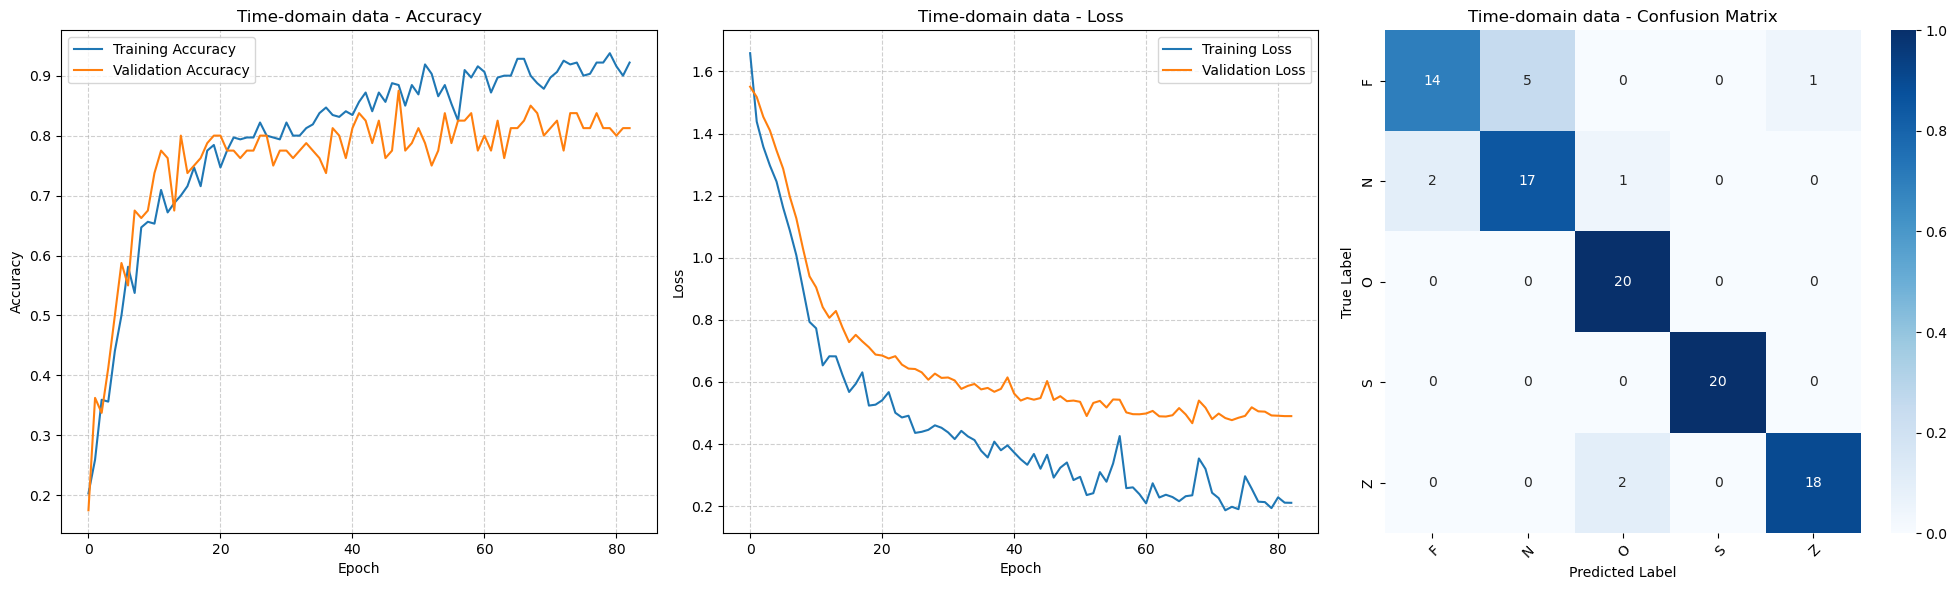

In [38]:
# Train and evaluate CNN for time-domain data
print("\n=== Training CNN on Time-Domain Data ===")
time_cnn_model = train_and_evaluate_cnn(X_train_time, X_test_time, y_train_time, y_test_time, 
                                        "Time-domain data", is_time_domain=True)


=== Training CNN on Frequency-Domain Data ===
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2423 - loss: 1.5498 - val_accuracy: 0.3500 - val_loss: 1.4982
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4098 - loss: 1.3619 - val_accuracy: 0.4000 - val_loss: 1.4423
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3423 - loss: 1.3576 - val_accuracy: 0.4125 - val_loss: 1.4051
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3975 - loss: 1.2760 - val_accuracy: 0.3750 - val_loss: 1.3726
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3842 - loss: 1.3014 - val_accuracy: 0.4500 - val_loss: 1.3493
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3960 - loss: 1.2571 - val_accuracy: 0.4625 - val_loss: 1.3101
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4602 - loss: 1.1937 - val_accuracy: 0.4875 - val_loss: 1.2865
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0

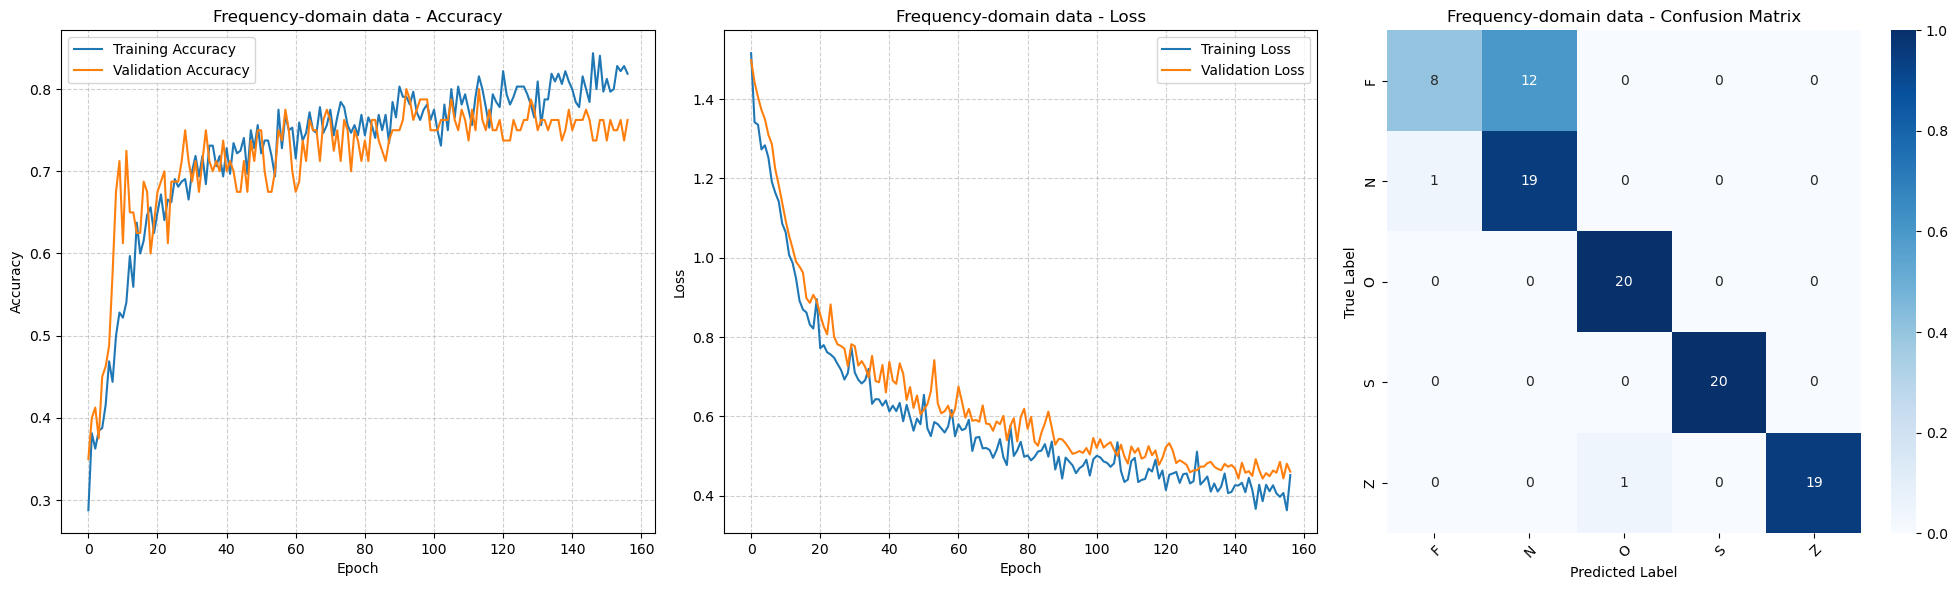

In [42]:
# Train and evaluate CNN for frequency-domain data
print("\n=== Training CNN on Frequency-Domain Data ===")
freq_cnn_model = train_and_evaluate_cnn(X_train_freq, X_test_freq, y_train_freq, y_test_freq, 
                                        "Frequency-domain data", is_time_domain=False)

### Conclusions?